In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from langdetect import detect, LangDetectException
from tqdm.auto import tqdm

In [2]:
# !wget https://downloads.wortschatz-leipzig.de/corpora/ces_wikipedia_2021_1M.tar.gz
# !tar -xzvf ces_wikipedia_2021_1M.tar.gz

In [3]:
sns.set_style("whitegrid")

In [4]:
file_path = 'ces_wikipedia_2021_1M/ces_wikipedia_2021_1M-sentences.txt'
df = pd.read_csv(file_path, sep='\t', header=None, names=['id', 'text'])
df.head()

,id,text
0,1,; 10. srpna : První vlna záplav skončila a zač...
1,2,;11/2013 :MPSV podalo k zakázce na provoz IT s...
2,3,;1/2010 :systém Státní pokladny měl být uveden...
3,4,;1/2014 :Systém pro vyplácení sociálních dávek...
4,5,;1/2020 :Služby CRAB poskytuje nový dodavatel ...


Basic data cleaning: remove missed text, duplicates

In [5]:
df.dropna(subset=['text'], inplace=True)

In [6]:
initial_count = len(df)
df.drop_duplicates(subset=['text'], inplace=True)
print(f"Removed {initial_count - len(df)} duplicate sentences.")
print(f"Corpus now has {len(df)} unique sentences.")

Removed 1 duplicate sentences.
Corpus now has 972845 unique sentences.


Basic statisctics

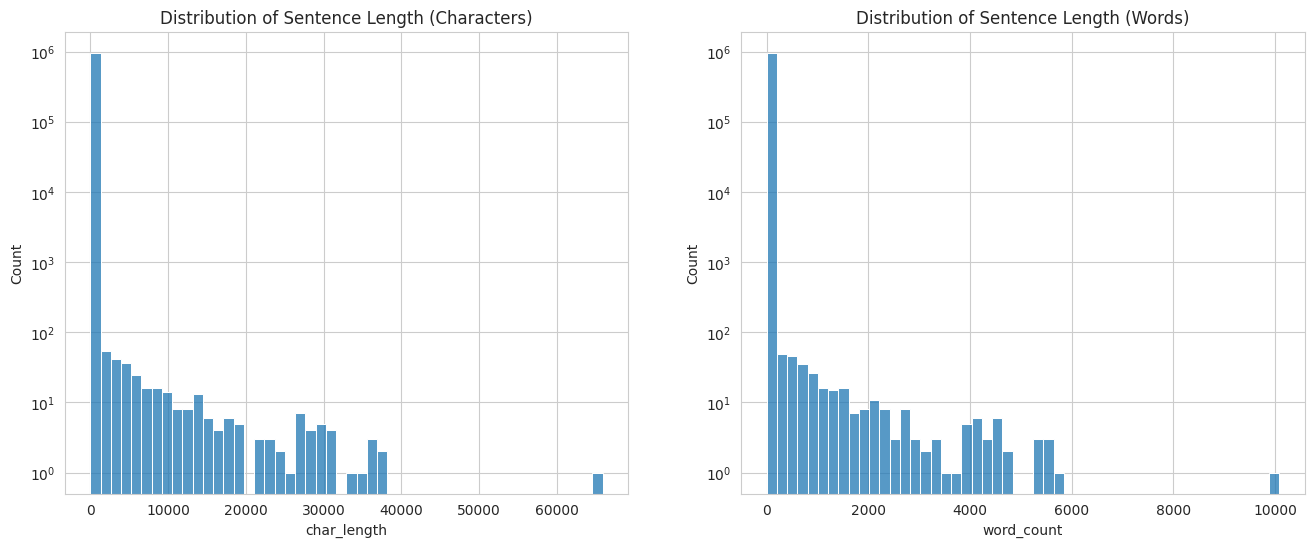

In [7]:
df['char_length'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(df['char_length'], bins=50, ax=axes[0])
axes[0].set_yscale("log")
axes[0].set_title('Distribution of Sentence Length (Characters)')

sns.histplot(df['word_count'], bins=50, ax=axes[1])
axes[1].set_title('Distribution of Sentence Length (Words)')
axes[1].set_yscale("log")

plt.show()

Language cleaning

In [8]:
# df = df.sample(n=5000, random_state=42)

In [9]:
from langdetect import DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

In [10]:
DetectorFactory.seed = 0

In [11]:
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return 'unknown'

In [12]:
tqdm.pandas()

In [13]:
df['language'] = df['text'].progress_apply(detect_language)

  0%|          | 0/972845 [00:00<?, ?it/s]

In [14]:
language_counts = df['language'].value_counts()
print(language_counts.head(15))

language
cs    958182
sk      7778
sl      1833
en      1374
hr       853
de       520
it       266
pt       237
pl       228
id       218
fr       216
es       167
ro       131
hu       107
ca        95
Name: count, dtype: int64


In [15]:
czech_df = df[df['language'] == 'cs'].copy()

print(f"Original number of sentences: {len(df)}")
print(f"Number of Czech sentences: {len(czech_df)}")
print(f"Filtered out {len(df) - len(czech_df)} non-Czech or unknown sentences.")

Original number of sentences: 972845
Number of Czech sentences: 958182
Filtered out 14663 non-Czech or unknown sentences.


Text cleaning: to lower, remove urls, remove citations (since we work with wikipedia), leave only Czech alphabet, normalize whitespace, etc

In [16]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[^a-záčďéěíňóřšťúůýž0-9\s.,!?-]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [17]:
czech_df['cleaned_text'] = czech_df['text'].progress_apply(clean_text)

  0%|          | 0/958182 [00:00<?, ?it/s]

In [18]:
czech_df[['text', 'cleaned_text']].head(10)

,text,cleaned_text
0,; 10. srpna : První vlna záplav skončila a zač...,10. srpna první vlna záplav skončila a začal v...
1,;11/2013 :MPSV podalo k zakázce na provoz IT s...,112013 mpsv podalo k zakázce na provoz it syst...
2,;1/2010 :systém Státní pokladny měl být uveden...,12010 systém státní pokladny měl být uveden do...
3,;1/2014 :Systém pro vyplácení sociálních dávek...,12014 systém pro vyplácení sociálních dávek po...
4,;1/2020 :Služby CRAB poskytuje nový dodavatel ...,12020 služby crab poskytuje nový dodavatel mer...
5,;12/2017 :NKÚ zveřejnil výsledek kontrolní akce.,122017 nkú zveřejnil výsledek kontrolní akce.
6,; : 130 Su-24 ve službě k listopadu 2008.,130 su-24 ve službě k listopadu 2008.
7,​​13. prosince roku 1971 se beze stopy ztratil...,13. prosince roku 1971 se beze stopy ztratila ...
8,“ (17. až 19. století).,17. až 19. století.
9,"17 vychází v limitované edici s bonusovým DVD,...","17 vychází v limitované edici s bonusovým dvd,..."


Remove very short sentences

In [19]:
czech_df['cleaned_char_length'] = czech_df['cleaned_text'].str.len()
czech_df['cleaned_word_count'] = czech_df['cleaned_text'].str.split().str.len()

In [20]:
min_word_count = 3
original_count = len(czech_df)
czech_df = czech_df[czech_df['cleaned_word_count'] >= min_word_count]
print(f"Removed {original_count - len(czech_df)} sentences with fewer than {min_word_count} words.")
print(f"Final corpus size: {len(czech_df)} clean sentences.")

Removed 59 sentences with fewer than 3 words.
Final corpus size: 958123 clean sentences.


In [21]:
output_filename = 'ces_wikipedia_2021_1M/cleaned_czech_corpus_for_training.txt'
cleaned_sentences = czech_df['cleaned_text']
cleaned_sentences.to_csv(output_filename, index=False, header=False)

In [2]:
import re

In [3]:
input_filename = 'ces_wikipedia_2021_1M/cleaned_czech_corpus_for_training.txt'
with open(input_filename, 'r', encoding='utf-8') as f:
    text = f.read()

In [4]:
chars = sorted(list(set(text)))
vocab_size = len(chars)

In [5]:
print(f"The corpus contains {vocab_size} unique characters.")
print("Current character vocabulary:")
print(''.join(chars))

The corpus contains 59 unique characters.
Current character vocabulary:

 !",-.0123456789?abcdefghijklmnopqrstuvwxyzáéíóúýčďěňřšťůž
